## Import Libraries and Set Up

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
random.seed(42)
np.random.seed(42)


## Define Dataset Paths

In [2]:
DATASET_PATH = r"C:\\Users\\Sagar Dahal\\Downloads\\FYPdataset"
COVID_PATH = os.path.join(DATASET_PATH, "COVID")
NORMAL_PATH = os.path.join(DATASET_PATH, "Normal")

print("Checking Dataset Path:")


Checking Dataset Path:


## Load and Preprocess Images

In [3]:
def load_images(path, label, image_size=(224, 224)):
    images, labels = [], []
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f" Error reading image: {img_path}")
                continue
            img = cv2.resize(img, image_size)
            img = cv2.GaussianBlur(img, (5, 5), 0)
            img = cv2.medianBlur(img, 5)
            img = img / 255.0
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f" Error loading {img_path}: {e}")
            continue
    return images, labels

covid_images, covid_labels = load_images(COVID_PATH, 1)
normal_images, normal_labels = load_images(NORMAL_PATH, 0)

print(f" Loaded {len(covid_images)} COVID images and {len(normal_images)} NORMAL images.")


 Loaded 3616 COVID images and 10192 NORMAL images.


## Display Sample Images

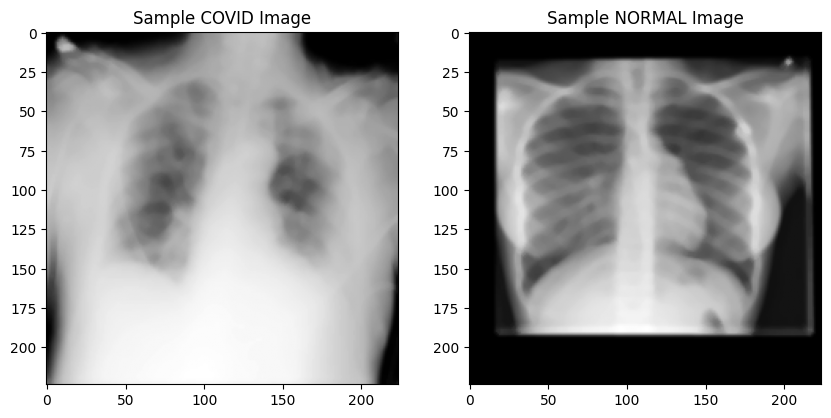

In [4]:
if len(covid_images) > 0 and len(normal_images) > 0:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(covid_images[0], cmap='gray')
    plt.title("Sample COVID Image")

    plt.subplot(1,2,2)
    plt.imshow(normal_images[0], cmap='gray')
    plt.title("Sample NORMAL Image")

    plt.show()
else:
    print(" No images loaded. Fix dataset paths or formats.")


## Balance Dataset and Split

In [5]:
balanced_normal_images = normal_images[:len(covid_images)]
balanced_normal_labels = normal_labels[:len(covid_images)]

images = np.array(covid_images + balanced_normal_images)
labels = np.array(covid_labels + balanced_normal_labels)

print(f" Total balanced dataset: {len(images)} images.")

images = images.reshape(-1, 224, 224, 1)
labels = to_categorical(labels, 2)

X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.30, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f" Dataset Split - Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


 Total balanced dataset: 7232 images.
 Dataset Split - Train: 5062, Val: 1085, Test: 1085


## Build the CNN Model

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\Sagar Dahal\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,168,642 (42.60 MB)

 Trainable params: 11,168,642 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

## Train and Visualize

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 250s 779ms/step - accuracy: 0.6215 - loss: 0.6473 - val_accuracy: 0.8083 - val_loss: 0.4385
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 231s 728ms/step - accuracy: 0.7730 - loss: 0.4741 - val_accuracy: 0.8479 - val_loss: 0.3511
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 247s 781ms/step - accuracy: 0.8448 - loss: 0.3618 - val_accuracy: 0.8986 - val_loss: 0.2632
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 244s 770ms/step - accuracy: 0.8763 - loss: 0.2970 - val_accuracy: 0.9069 - val_loss: 0.2312
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 248s 782ms/step - accuracy: 0.9037 - loss: 0.2384 - val_accuracy: 0.9171 - val_loss: 0.2232
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 254s 799ms/step - accuracy: 0.9217 - loss: 0.1908 - val_accuracy: 0.9327 - val_loss: 0.1933
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 270s 851ms/step - accuracy: 0.9369 - loss: 0.1652 - val_accuracy: 0.9088 - val_loss: 0.2483
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 257s 809ms/step - accuracy: 0.9413 -

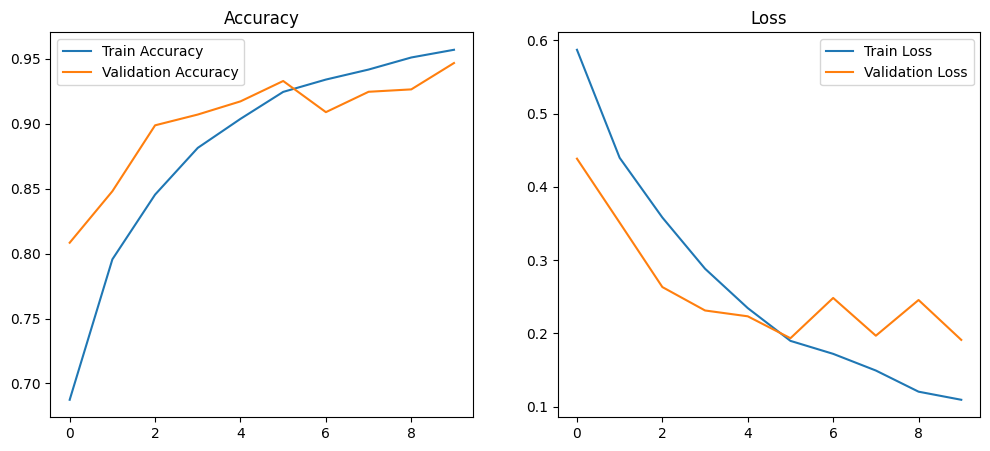

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


## Evaluate Model

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f" Test Accuracy: {test_acc:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.9349 - loss: 0.1794
 Test Accuracy: 0.9309
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 263ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       542
           1       0.92      0.95      0.93       543

    accuracy                           0.93      1085
   macro avg       0.93      0.93      0.93      1085
weighted avg       0.93      0.93      0.93      1085



## Confusion Matrix


Confusion Matrix (Numeric):
[[496  46]
 [ 29 514]]


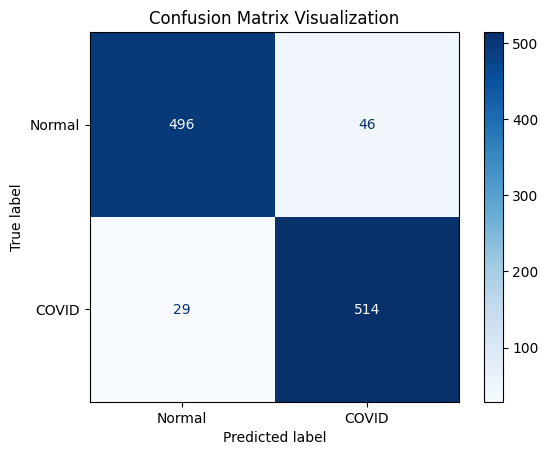

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("\nConfusion Matrix (Numeric):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Visualization")
plt.show()


## Save Model

In [10]:
model.save("covid19_cnn_model_debug.h5")
print(" Model Saved Successfully ")


 Model Saved Successfully 
